# W207 Spring 2019 Final Project
## Kaggle Competition: Forest Cover Prediction
**Pierce Coggins, Jake Mitchell, Debasish Mukhopadhyay, and Tim Slade**

# Table of Contents/Section Notes

- [Introduction](#introduction)
  - In which we discuss the problem and why it matters
  - [Housekeeping](#housekeeping)
    - In which we deal with basic prep and setup issues
- [About the Data](#aboutTheData)
  - EDA, charts, data cleaning
- [Feature Engineering](#featureEngineering)
  - Describe a basic model that we will use to test the usefulness of new features (LR or NB)
  - Normalization
  - Each added or removed feature
- [Models](#models)
  - Maybe choose 4 to test out?  Don't want this section to get too lengthy, and each model should be covered in some detail
- [Results](#results)
  - What went well, what went poorly
  - Final comparison of models on test data
- [Conclusion](#conclusion)
- [Annexes](#annexA)
  

<a id="introduction"></a>
# Introduction

In this report, we will attempt to predict the forest cover type (defined as the predominant type of tree cover) for a given area of land in Colorado given only cartographic variables as inputs.  This problem and dataset were initially posted as a Kaggle competition in 2015.  We have chosen to tackle this problem as it allows for many different machine learning techniques to be attempted and explored.  The report will go through the process of building a capable model from data cleaning through final testing.

The problem of understanding what type of vegetation is present in a difficult to access area is a surprisingly important one.  In this particular example the forests of Colorado are very diverse, and each type of tree cover has its own benefits and dangers.  For example, many of the pine trees in Colorado are susceptible to the [mountain pine beetle](https://csfs.colostate.edu/forest-management/common-forest-insects-diseases/mountain-pine-beetle/), while the Spruce and Fir trees are relatively safe from the beetles.  Without directly going to every location in the mountains of Colorado, it is very difficult to distinguish these types of trees as they look very similar from the air.  It is relatively easy to get cartographic data for a large swath of the mountains, however, and if it is possible to accurately predict the tree type from the cartographic information alone then all of the Colorado forest could be mapped by likely forest cover type. That information would be invaluable to firefighters and forest service personnel to direct their efforts where it will have the most impact.

If you would like to learn more about the problem or try for yourself, all information and data can be found from the kaggle competition:<br>[Kaggle's Forest Cover Type Prediction](https://www.kaggle.com/c/forest-cover-type-prediction).

<a id="housekeeping"></a>
## Housekeeping

### Importing Libraries, Helper Functions, and Loading Data

In [1]:
%%capture
# %matplotlib inline
# %matplotlib notebook
%matplotlib qt

# General libraries
import pandas as pd
import numpy as np
import os
import copy
import warnings
import statsmodels.api as sm
from scipy import stats
import math

# Plotting and printing libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import pprint

# Model-building libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler, RobustScaler, Normalizer, scale

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

# SK-learn libraries for evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Run the helper functions notebook
%run w207_final_helper_functions.ipynb

The forest cover types we aim to predict are bundled with the features used to predict them. Our first step is therefore to separate them out, lest we accidentally let our models peek at the outcomes. We also want to split the dataset into _train_ and _test_ subsets; this will give us insight into how well our chosen models and parameters will perform against out-of-sample data.

The original dataset contained 15,120 observations. We will train our models on 90% of the data and hold out 10% for testing. We thus expect to have approximately 0.9 * 15,120 = 13,608 observations in our training dataset.

In [2]:
%%capture --no-stdout --no-display
full_data = pd.DataFrame.from_csv('./train.csv')
full_data.shape

# Separating out the labels
full_labels = full_data['Cover_Type']
full_features = full_data.drop('Cover_Type', axis=1)

# Setting seed so we get consistent results from our splitting
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(full_features, full_labels, test_size=0.10)

# Verifying our data shapes are as expected
print(f'''
{'':^16} | {'Observations':^12} | {'Features':^10} |
{'-'*46}
{'Training dataset':^16} | {X_train.shape[0]:^12} | {X_train.shape[1]:^10} |
{'Training labels':^16} | {y_train.shape[0]:^12} | {'--':^10} |
{'Test dataset':^16} | {X_test.shape[0]:^12} | {X_test.shape[1]:^10} |
{'Test labels':^16} | {y_test.shape[0]:^12} | {'--':^10} |
''')


                 | Observations |  Features  |
----------------------------------------------
Training dataset |    13608     |     54     |
Training labels  |    13608     |     --     |
  Test dataset   |     1512     |     54     |
  Test labels    |     1512     |     --     |



<a id="aboutTheData"></a>

<a id="aboutTheData"></a>
# About the Data

The data comes from several wilderness areas in northern Colorado, specifically the Rawah Wilderness Area, Neota Wilderness Area, Comanche Peak Wilderness Area, and the Cache la Poudre Wilderness Area.  These are all fairly remote areas of Colorado, which may be why they were chosen; there is less human influence in these places to complicate the prediction task.

The features in the dataset are all cartographic measures of a 30x30m square plot of land.  We have 10 simple features. The 11th and 12th - `wilderness_area` and `soil_type` - are categorical variables which are represented as 4 and 40 binary columns respectively in our dataset. We therefore have a total of 10 + 4 + 40 = 54 features to work with.
The list below contains a short description of each feature, including where relevant its range, median, and mean. (See [Annex A](#annexA) for the associated code and further discussion of the exploratory data analysis).

- `Elevation`: _Elevation in meters_
  - **Range**: 1863 to 3849 | **Mean**: 2749.3 | **Median**: 2752


- `Aspect`: _Aspect in degrees azimuth. i.e., degrees clockwise from a line pointed at true North. So North = 0$^\circ$, East = 90$^\circ$, South = 180$^\circ$, and West = 270$^\circ$_
  - **Range**: 0 to 360 | **Mean**: 156.7 | **Median**: 126.0


- `Slope`: _Slope in degrees. 0$^\circ$ would indicate a flat plane; greater values represent steeper slopes._
  - **Range**: 0 to 52 | **Mean**: 16.5 | **Median**: 15.0 


- `Horizontal_Distance_To_Hydrology`: _Horizontal distance to nearest surface water features. Units unspecified._
  - **Range**: 0 to 1343 | **Mean**: 227.2 | **Median**: 180 


- `Vertical_Distance_To_Hydrology`: _Vertical distance to nearest surface water features. Units unspecified._
  - **Range**: -146 to 554 | **Mean**: 51.1 | **Median**: 32.0


- `Horizontal_Distance_To_Roadways`: _Horizontal distance to nearest roadway. Units unspecified._
  - **Range**: 0 to 6890 | **Mean**: 1714.0 | **Median**: 1316


- `Hillshade_9am`: _(0 to 255 index) - Hillshade index at 9am, summer solstice_
  - **Range**: 0 to 254 | **Mean**: 212.7 | **Median**: 220


- `Hillshade_Noon`: _(0 to 255 index) - Hillshade index at noon, summer solstice_
  - **Range**: 99 to 254 | **Mean**: 219.0 | **Median**: 223


- `Hillshade_3pm`: _(0 to 255 index) - Hillshade index at 3pm, summer solstice_
  - **Range**: 0 to 248 | **Mean**: 135.1 | **Median**: 138.0


- `Horizontal_Distance_To_Fire_Points`: _Horizontal distance to nearest wildfire ignition points. Units unspecified._
  - **Range**: 0 to 6993 | **Mean**: 1511.2 | **Median**: 1256 


- `Wilderness_Area`: _(4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation_
  - % of cases - **Area 1**: 24% || **Area 2**: 3% || **Area 3**: 42% || **Area 4**: 31% 


- `Soil_Type`: _(40 binary columns, 0 = absence or 1 = presence) - Soil type designation_
  - The soil types descriptions can be found at the [Kaggle Competition Data Page](https://www.kaggle.com/c/forest-cover-type-prediction/data)

### Initial Exploration of the Challenge
The label indicating our data's categorization is contained in the`Cover_Type` variable, and is split up into 7 different designations. While the tree species discussed in the Colorado State Forest Service's [_Colorado's Major Tree Species_](https://csfs.colostate.edu/colorado-trees/colorados-major-tree-species/) article do not map perfectly to these categories, the article provides some insights that may prove useful in our categorization exercise.

#### <span style='color:blue'>Category 1</span>: 'Spruce/Fir'
- Species that might fit into this category include the **Blue Spruce** (which thrives at an altitude of 6700-11500 ft in sandy soils near moisture), the **Engelmann Spruce** (8000-11000 ft, moist north-facing slopes), the **Subalpine Fir** (8000-12000 ft, cold high-elevation forests), and the **White Fir** (7900-10200 ft, moist soils in valleys).

<center>Blue Spruce</center> | <center>Engelmann Spruce</center> | <center>Subalpine Fir</center> | <center>White Fir</center>
- | - | - | -
<img src="imgs/1_blue-spruce-tree.jpg" alt="BlueSpruce" style="width: 250px;"/>  | <img src="imgs/1_engelmann-spruce.jpg" alt="EngelmannSpruce" style="width: 250px;"/> | <img src="imgs/1_subalpine-fir.jpg" alt="SubalpineFir" style="width: 250px;"/> | <img src="imgs/1_white-fir-tree.jpg" alt="WhiteFir" style="width: 250px;"/>

#### <span style='color:blue'>Category 2</span>: 'Lodgepole Pine' and <span style='color:blue'>Category 3</span>: 'Ponderosa Pine'
- The **Lodgepole Pine** thrives in well-drained soils at high elevations (6000-11000 ft).
- The **Ponderosa Pine** thrives in dry, nutrient-poor soils at elevations of 6300-9500 ft. It is often found with Douglas Firs.

<center>Lodgepole Pine</center> | <center>Ponderosa Pine</center> |
- |-|
<img src="imgs/2_lodgepole-pine.jpg" alt="LodgepolePine" style="width: 250px;"/> | <img src="imgs/3_ponderosa-pine.jpg" alt="PonderosaPine" style="width: 250px;"/> |

#### <span style='color:blue'>Category 4</span>: 'Cottonwood/Willow'
- Species that might fit into this category include the **Plains Cottonwood** (which thrives at altitudes of 3500-6500 ft near sources of water), the **Narrowleaf Cottonwood** (5000-8000 ft, moist soils along streams), and the **Peachleaf Willow** (3500-7500 ft, near water sources).

<center>Plains Cottonwood</center> | <center>Narrowleaf Cottonwood</center> | <center>Peachleaf Willow</center> |
- |- |- |
<img src="imgs/4_plains-cottonwood.jpg" alt="PlainsCottonwood" style="width: 250px;"/> |<img src="imgs/4_narrowleaf-cottonwood.jpg" alt="NarrowleafCottonwood" style="width: 250px;"/> |<img src="imgs/4_peachleaf-willow.jpg" alt="PeachleafWillow" style="width: 250px;"/> |

#### <span style='color:blue'>Category 5</span>: 'Aspen' and <span style='color:blue'>Category 6</span>: 'Douglas Fir'
- The **Quaking Aspen** thrives at altitudes of 6500-11500 ft. While it can be in many soil types, it is especially found on sandy and gravelly slopes.
- The **Douglas Fir** thrives at altitudes of 6000-9500 ft in rocky soils of moist northern slopes.

<center>Quaking Aspen</center> | <center>Douglas Fir</center> |
- | - |
<img src="imgs/5_aspen.jpg" alt="QuakingAspen" style="width: 250px;"/> | <img src="imgs/6_douglas-fir.jpg" alt="DouglasFir" style="width: 250px;"/>|

#### <span style='color:blue'>Category 7</span>: 'Krummholz'
- Interestingly, _krummholz_ is not a species of tree; it is a type of tree formation (which can emerge among various tree species) that results from consistent long-term exposure to strong, cold winds. Per [Wikipedia](https://en.wikipedia.org/wiki/Krummholz), Subalpine Fir and Engelmann Spruce are often associated with Krummholz conditions (as is Lodgepole Pine, although that is more common in British Columbia).

<center>Krummholz Banner Tree</center> | <center>Krummholz White Pine</center> | <center>Krummholz Bristlecone</center> 
- |- |- |
<img src="imgs/7_krummholz-banner-tree.jpg" alt="KrummholzBannerTree (Photo credit to John Spooner - flickr.com, CC BY 2.0, https://commons.wikimedia.org/w/index.php?curid=5007578)" style="width: 250px;"/> | <img src="imgs/7_krummholz-white-pine.jpg" alt="KrummholzWhitePine (Photo credit to Walter Siegmund [CC BY-SA 3.0 (https://creativecommons.org/licenses/by-sa/3.0)] https://commons.wikimedia.org/wiki/File:Pinus_albicaulis_7872.JPG" style="width: 350px;"/> |  <img src="imgs/7_krummholz-windswept-bristlecone.jpg" alt="KrummholzBristlecone" style="width: 400px;"/> | 


### Where do we start?

The brief descriptions we've seen already suggest some avenues of exploration: altitude ranges and access to water seem to be of primary importance.

#### What can we learn from elevation alone?

One place to begin would be to plot out the idealized elevation ranges within which the various tree species thrive. There may be certain elevations where certain tree species would be far more prevalent than others. The graph below illustrates the ranges in which the species of trees discussed the Colorado State Forest Service's [_Colorado's Major Tree Species_](https://csfs.colostate.edu/colorado-trees/colorados-major-tree-species/) thrive, per the article.

<img src="imgs/altitudeRanges4.png" alt="ElevationRangesIdealized" style="width: 800px;"/>

It appears that lower elevations would be strongly suggestive of the `Cottonwood/Willow` `Cover_Type`, while higher elevations might be more suggestive of the `Spruce/Fir`, `Lodgepole Pine`, `Aspen`, and `Krummholz` `Cover_Type`s. The graph above is based upon idealized data from outside sources, though, and our actual dataset might tell a different story. The graphs below present the observed _elevation_ ranges and quartiles by `Cover_Type` in our data.

| <center>Elevation Ranges</center> | <center>Elevation Quartiles</center>
|-|-
|<img src="imgs/elevationRanges.png" alt="ElevationRanges" style="width: 600px;"/> |<img src="imgs/elevationQuartiles.png" alt="ElevationQuartiles" style="width: 600px;"/> |

When looking at the ranges, our dataset appears to differ from the idealized one in that the `Cottonwood/Willow` `Cover_Type` does not seem to occur at markedly lower elevations. When looking at the quartiles, though, patterns emerge that appear similar to what we would expect from the idealized presentation: `Cottonwood/Willow` tends to cluster at lower elevations, with the higher elevations dominated by `Spruce/Fir` and `Krummholz` cover types.

The separations are surprisingly clean, suggesting that `Elevation` will be a powerful feature in our models. It might be especially powerful if we could develop a method to cluster the altitudes into the interquartile ranges presented in the model above.

#### What if we bring water into the picture?
The other feature that the article suggests might be highly salient is moisture. How does the picture evolve if we add a measure of the distance to water to the mix?

The graph below is a scatterplot of the Euclidean distance (derived from the `Horizontal_Distance_To_Hydrology` and `Vertical_Distance_To_Hydrology` features) and the `Elevation`, with data points colored by the `Cover_Type`.

<img src="imgs/hydrologyAndElevationScatter.png" alt="HydrologyAndElevationScatter" style="width: 600px;"/>

The distance to hydrology appears to be informative: `Cover_Type`s 3, 4, and 6 are essentially not found when the distance to water exceeds 750. That said, it remains clear that `Elevation` is the predominant distinguishing feature.

#### What if we consider exposure to sunlight and wind?
From a layperson's perspective, the amount of sunlight to which a given plot of land is exposed would seem likely to influence the vegetation which thrives there. In our dataset, the `Hillshade` variables encode this information.

The plot below compares the 1st quartile, median, and 3rd quartiles for each measure of `Hillshade` for each category of `Cover_Type`.

<img src="imgs/hillshadeQuartiles.png" alt="HillshadeQuartiles" style="width: 600px;"/>

While the median `Hillshade` values appear to vary a little across categories in the morning and afternoon, the interquartile range largely overlaps across categories. The overall impression is that `Hillshade` is unlikely to be determinative on its own.

Exposure to sunlight and wind would also be affected by the `Aspect`, which is essentially the compass direction (0$^\circ$ is true North, 90$^\circ$ is East, 180$^\circ$ is South, 270$^\circ$ is West) the plot is facing. While the exact nature of the interaction between these features may not be clear *a priori*, we can attempt to collapse the effect into a single feature by taking the first principal component of the `Hillshade_9am` and `Hillshade_3pm` features with the `Aspect` feature.

The graph below plots this first principal component against `Elevation`, as we already know `Elevation` is strongly informative.

<img src="imgs/hillshadeAspectPcaScatter.png" alt="hillshadeAspectPcaScatter" style="width: 600px;"/>

What patterns we see are weak at best. While the `Douglas Fir` category appears to be more prevalent for greater and lesser values of this first principal component, and the `Ponderosa Pine` appears to be slightly more prevalent nearer to zero, it is clear that the `Elevation` remains the dominant feature.

#### What about the 'Kitchen Sink' approach?

So far we've examined `Elevation`, `Hydrology`, `Aspect`, and `Hillshade` features on the basis of the write-ups regarding the various tree species. But what if we just took a look at all of our key features and how they relate to one another?

The graph below is a scatterplot matrix incorporating all of the raw simple features in our data, as well as the `Euclidean_Distance_To_Hydrology` feature we composed from the horizontal and vertical distances to hydrology.

<img src="imgs/scatterplotMatrixElevationAspectWaterHillshade.png" alt="scatterplotMatrixElevationAspectWaterHillshade" style="width: 800px;"/>

While `Elevation` remains the feature that seems to provide the cleanest separation between `Cover_Type`s, two additional features seem to perform pretty well at discriminating the `Lodgepole Pine`s: `Horizontal_Distance_To_Roadways` and `Horizontal_Distance_To_Fire_Points`.

### Cleaning the Data
While exploring the data (see [Annex A](#annexA)), we noted that the `Soil_Type7` and `Soil_Type15` variables are never true. Because there is no variation in this feature, it contributes nothing to any of our models.

In [3]:
# Removing uninformative features
full_features = full_features.drop(['Soil_Type7', 'Soil_Type15'], axis=1)

<a id="featureEngineering"></a>
# Feature Engineering

Successful machine learning projects often depend heavily on feature engineering. The most important feature in a dataset may be a latent one - that is, 'hidden' behind other features which serves as proxies for it. In such a case, the latent feature needs to be explicitly extracted. While we are exploring the potential of various synthetic/constructed features, we will also try to remove original features which are proving uninformative. Doing so will reduce the noise passed into our models. We can keep the engineered and source datasets separate by creating a deep copy of the data.

### Euclidean Distance to Hydrology

As we saw in the [About the Data](#aboutTheData) section, the `Cover_Type`s can be visually broken up based on their distance to hydrology, both horizontally and vertically.  By combining the features into a single feature, we can reduce the overall number of features.

### Elevation of Hydrology

Elevation and Hydrology are very important features when it comes to predicting the `Cover_Type` of an area.  By subtracting the vertical distance to hydrology from the elevation, we can find what the elevation of the hydrology itself it.  This may prove useful by providing a feature that would be able to discern an alpine lake vs a valley stream.

### Mean Distance to Feature

As we saw in the [About the Data](#aboutTheData) section, the distance metrics group the data pretty well for classification.  We can engineer a new feature that incorporates the mean distance to hydrology, fire points, and roadways - the latter two features providing a fair approximation of an area's remoteness.

### Stony

This data set features 40 different types of soils.  When compared to the 7 possible labels, this number of soil types seems a bit extreme.  Different types of trees favor more rocky soils, and so combining all of the stony soil types into a single feature will allow a model to more easily pick up on that.

### Hillshade

In [4]:
full_features[['Hillshade_9am', 'Hillshade_3pm']].describe()

,Hillshade_9am,Hillshade_3pm
count,15120.000000,15120.000000
mean,212.704299,135.091997
std,30.561287,45.895189
min,0.000000,0.000000
25%,196.000000,106.000000
50%,220.000000,138.000000
75%,235.000000,167.000000
max,254.000000,248.000000


### Key Data Assumptions Made

One thing to notice about the data is that the `Hillshade_9am` and `Hillshade_3pm` features are missing several values.  We choose to replace these values with the median value for those features.  This will allow the areas with missing values to be more accurately classified as they no longer have un-usable data.

In [5]:
engineered_features = pd.DataFrame.copy(full_features)
engineered_features['Euclidean_Distance_To_Hydrology'] = engineered_features.apply(lambda row: math.sqrt(row.Horizontal_Distance_To_Hydrology**2 + row.Vertical_Distance_To_Hydrology**2), axis=1)
engineered_features['Elevation_Of_Hydrology'] = engineered_features['Elevation']-engineered_features['Vertical_Distance_To_Hydrology']
engineered_features['Mean_Distance_To_Feature'] = (engineered_features['Horizontal_Distance_To_Hydrology']+engineered_features['Horizontal_Distance_To_Roadways']+engineered_features['Horizontal_Distance_To_Fire_Points'])/3
engineered_features['Stony'] = engineered_features[['Soil_Type1', 'Soil_Type2', 'Soil_Type6', 'Soil_Type9', 'Soil_Type12', 'Soil_Type18', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', ]].any(axis=1)
median_hillshade_9am = np.median(engineered_features['Hillshade_9am'])
engineered_features['Hillshade_9am'] = engineered_features.apply(lambda row: median_hillshade_9am if row.Hillshade_9am == 0 else row.Hillshade_9am, axis=1)
median_hillshade_3pm = np.median(engineered_features['Hillshade_3pm'])
engineered_features['Hillshade_3pm'] = engineered_features.apply(lambda row: median_hillshade_3pm if row.Hillshade_3pm == 0 else row.Hillshade_3pm, axis=1)

np.random.seed(0)
e_X_train, e_X_test, e_y_train, e_y_test = train_test_split(engineered_features, full_labels, test_size=0.10)

### How to Test Feature Changes

Without _a priori_ knowledge of how the interplay between soil types, topography, hydrology, etc. affects forest cover, we need a way to view the performance of new features.  As such we will use a simple Gaussian Naive Bayes model to do predictions, and quanitify the results using cross-validation.  We will be tracking performance across precision, recall, and f1-score.

#### Naïve Bayes

One reasonable place to begin might be a Naïve Bayes classifier. While it is unlikely that all of the features at our disposal are _strictly_ independent, we may be able to relax the assumption of independence enough to explore how a NB model performs.

We don't want a Bernoulli NB model: our features are not uniformly binary-valued. We also don't want a Multinomial NB model: per the documentation, it assumes integer feature counts. A Gaussian NB, on the other hand, might work well. While it assumes that the likelihoods of the features are Gaussian - and this is not necessarily strictly the case - it may be worth trying.

In [6]:
# Testing on the base data
cross_validate_model(GaussianNB(), X_train, y_train, name='Base Data GaussianNB', verbose=True)

# Testing on the engineered data
cross_validate_model(GaussianNB(), e_X_train, e_y_train, name='Base Data GaussianNB', verbose=True)

Model: Base Data GaussianNB, with 5 folds
			Spruce/Fir           | precision:  0.72 | recall:  0.50 | f1-score:  0.59 | 
			Lodgepole Pine       | precision:  0.13 | recall:  0.73 | f1-score:  0.22 | 
			Ponderosa Pine       | precision:  0.73 | recall:  0.43 | f1-score:  0.54 | 
			Cottonwood/Willow    | precision:  0.92 | recall:  0.68 | f1-score:  0.78 | 
			Aspen                | precision:  0.73 | recall:  0.59 | f1-score:  0.65 | 
			Douglas Fir          | precision:  0.07 | recall:  0.77 | f1-score:  0.12 | 
			Krummholz            | precision:  0.82 | recall:  0.86 | f1-score:  0.84 | 
			macro avg            | precision:  0.59 | recall:  0.65 | f1-score:  0.54 | 
			micro avg            | precision:  0.59 | recall:  0.59 | f1-score:  0.59 | 
			weighted avg         | precision:  0.76 | recall:  0.59 | f1-score:  0.65 | 

Model: Base Data GaussianNB, with 5 folds
			Spruce/Fir           | precision:  0.73 | recall:  0.53 | f1-score:  0.61 | 
			Lodgepole Pine       | precision

In this report we will use two metrics to determine how well a particular model performs, precision and recall.  All in all, just throwing a Gaussian Naive Bayes classifier at the data performed better than expected.  It achieved a 76% weighted precision across 5 fold cross validation.  

The engineered features do not provide as much improvement as hoped.  They resulted in 1-2% improvements across all of the metrics.  One positive however is that the improved features seem to help the poorly classified labels more than the already well classified labels.

### Failed Engineered Features

Not every feature that is engineered is a useful addition to the data set.  Randomly adding new features can add noise to the dataset without providing any new information.  We have listed the failed features below.  Some highlights include mountain width and prominence (from the `Elevation` and `Slope` features), and a few different ways to view the elevation of an area.

In [7]:
# engineered_features['Elevation_Away_From_Hydrology'] = engineered_features['Elevation']-engineered_features['Horizontal_Distance_To_Hydrology']
# engineered_features['Mountain_Width'] = engineered_features.apply(lambda row: row.Elevation/math.tan(math.radians(row.Slope+.1)), axis=1)
# engineered_features['Mountain_Prominence'] = engineered_features.apply(lambda row: row.Elevation/math.sin(math.radians(row.Slope+.1)), axis=1)
# engineered_features['Mean_Hillshade'] = engineered_features.apply(lambda row: (row.Hillshade_9am + row.Hillshade_Noon + row.Hillshade_3pm)/3, axis=1)
# engineered_features['Morning_Hillshade'] = engineered_features.apply(lambda row: (row.Hillshade_9am * row.Hillshade_Noon), axis=1)
# engineered_features['Norm_Horizontal_Distance_To_Hydrology'] = engineered_features['Horizontal_Distance_To_Hydrology']/(np.mean(engineered_features['Horizontal_Distance_To_Hydrology']))
# engineered_features['Norm_Elevation'] = engineered_features['Elevation']/(np.mean(engineered_features['Elevation']))
# engineered_features['Log_Elevation'] = engineered_features.apply(lambda row: math.log(row.Elevation), axis=1)

### Standardization of the Features

Standardization is a very important aspect of preparing data for consumption by machine learning models.  It brings all of the features into a simlilar range, meaning that the models will not end up with widely varying coefficients due to the differing scales of features.  By ensuring all features exist within a given range, we eliminate the possibility that a feature could dominate the weighting and prediction process simply by virtue of having a range that is a few orders of magnitude greater than that of another (potentially more meaningful) feature.   We will experiment with several different types of standardization to see which is the most effective. Specifically we will test Min-Max scaling, standard scaling, robust scaling and sklearn's normalizer.

#### Evaluating standardization using K-Nearest Neighbors

One issue with Naïve Bayes models is that they are more or less invariant to feature scaling, and therefore cannot be used when testing different standardization methods.  We will use the `KNearestClassifier` with *K = 3* when testing out our performance on scaled data.  In testing a variety of values for `K`, we found that *K = 3* consistently produced the best results.

In [8]:
# Testing on the unscaled data
cross_validate_model(KNeighborsClassifier(n_neighbors=3), e_X_train, e_y_train, name='3 Nearest Neighbors', verbose=True)

Model: 3 Nearest Neighbors, with 5 folds
			Spruce/Fir           | precision:  0.66 | recall:  0.74 | f1-score:  0.70 | 
			Lodgepole Pine       | precision:  0.58 | recall:  0.71 | f1-score:  0.64 | 
			Ponderosa Pine       | precision:  0.74 | recall:  0.83 | f1-score:  0.78 | 
			Cottonwood/Willow    | precision:  0.96 | recall:  0.90 | f1-score:  0.93 | 
			Aspen                | precision:  0.96 | recall:  0.83 | f1-score:  0.89 | 
			Douglas Fir          | precision:  0.85 | recall:  0.80 | f1-score:  0.82 | 
			Krummholz            | precision:  0.97 | recall:  0.88 | f1-score:  0.92 | 
			macro avg            | precision:  0.82 | recall:  0.81 | f1-score:  0.81 | 
			micro avg            | precision:  0.82 | recall:  0.82 | f1-score:  0.82 | 
			weighted avg         | precision:  0.84 | recall:  0.82 | f1-score:  0.82 | 



The `KNearestClassifier` performed remarkably well on the base data with 83% precision and 81% recall.  This is a remarkably good result for a very basic model.  However with such a low K, it is important to keep overfitting in mind.

#### In brief: standardizing was unhelpful

We tested standardization of our feature set using the following models:
+ `MinMaxScaler` with ranges of [-1, 1] and [0, 1]
+ `StandardScaler` with the range [0, 1]
+ `RobustScaler`
+ `Normalizer`

The code block below demonstrates the effect of applying each of those standardization approaches. (Removing the `%%capture` line will allow the output to be generated.) Output is currently omitted for parsimony, however, because the central message was that no approach to standardization materially improved performance on the KNN test case. As a result we have also elided extended discussion of the way the various scalers function and the apparent (in)coherence of the transformed features.

In [9]:
%%capture
mm_neg1_1_scaled_df = apply_scaler(MinMaxScaler(feature_range=(-1, 1)), e_X_train)
print("MinMaxScaler [-1,1]")
mm_neg1_1_scaled_df.head(5)

mm_0_1_scaled_df = apply_scaler(MinMaxScaler(feature_range=(0, 1)), e_X_train)
print("MinMaxScaler [0,1]")
mm_0_1_scaled_df.head(5)

standard_scaled_df = apply_scaler(StandardScaler(), e_X_train)
print("StandardScaler [0,1]")
standard_scaled_df.head(5)

r_scaled_df = apply_scaler(RobustScaler(), e_X_train)
print("RobustScaler [0,1]")
r_scaled_df.head(5)

n_scaled_df = apply_scaler(Normalizer(), e_X_train)
print(n_scaled_df.shape)
n_scaled_df.head(10)

In [10]:
# Testing on the [-1,1] scaled data again for reference
cross_validate_model(KNeighborsClassifier(n_neighbors=3), mm_neg1_1_scaled_df, e_y_train, name='3 Nearest Neighbors, MinMax scaled [-1,1]')
# Testing on the [0,1] scaled data
cross_validate_model(KNeighborsClassifier(n_neighbors=3), mm_0_1_scaled_df, e_y_train, name='3 Nearest Neighbors, MinMax scaled [0,1]')
# Testing on the [0,1] scaled data
cross_validate_model(KNeighborsClassifier(n_neighbors=3), standard_scaled_df, e_y_train, name='3 Nearest Neighbors, Standard scaled [0,1]')
# Testing on the Robust scaled data
cross_validate_model(KNeighborsClassifier(n_neighbors=3), r_scaled_df, e_y_train, name='3 Nearest Neighbors, Robust scaled [0,1]')
# Testing on the Normalized data
cross_validate_model(KNeighborsClassifier(n_neighbors=3), n_scaled_df, e_y_train, name='3 Nearest Neighbors, Normalized')
# Testing on the unscaled data again for reference
cross_validate_model(KNeighborsClassifier(n_neighbors=3), e_X_train, e_y_train, name='3 Nearest Neighbors')

Model: 3 Nearest Neighbors, MinMax scaled [-1,1]
			weighted avg         | precision:  0.82 | recall:  0.81 | f1-score:  0.81 | 
Model: 3 Nearest Neighbors, MinMax scaled [0,1]
			weighted avg         | precision:  0.82 | recall:  0.81 | f1-score:  0.81 | 
Model: 3 Nearest Neighbors, Standard scaled [0,1]
			weighted avg         | precision:  0.81 | recall:  0.80 | f1-score:  0.80 | 
Model: 3 Nearest Neighbors, Robust scaled [0,1]
			weighted avg         | precision:  0.81 | recall:  0.80 | f1-score:  0.80 | 
Model: 3 Nearest Neighbors, Normalized
			weighted avg         | precision:  0.73 | recall:  0.70 | f1-score:  0.71 | 
Model: 3 Nearest Neighbors
			weighted avg         | precision:  0.84 | recall:  0.82 | f1-score:  0.82 | 


This test is to determine how much the scaled features affect the KNN model, so we have included the previous basic KNearestNeighbors results for reference.  
+ The range used when applying the `MinMaxScaler` does not materially affect the results.
+ The `StandardScaler` actually performs slightly worse than the `MinMaxScaler` when used on a KNN-3 model.
+ The `RobustScaler` performs approximately as well as the previous models.
+ The `Normalizer` generated the worst results of all.

Many of the sklearn models that we will deploy apply some built-in standardization before training. Since manually standardizing the features has not improved performance, the remainder of our exploration will use the unstandardized features.

<a id="models"></a>

# Models

### Logistic Regression

Logistic Regression is a useful model because it is quite interpretable (it is possible to extract the coefficients for individual features), and when given enough data can perform remarkably well.

In [11]:
cross_validate_model(LogisticRegression(), e_X_train, e_y_train, name='Logistic Regression', verbose=True)

Model: Logistic Regression, with 5 folds
			Spruce/Fir           | precision:  0.65 | recall:  0.62 | f1-score:  0.64 | 
			Lodgepole Pine       | precision:  0.50 | recall:  0.58 | f1-score:  0.54 | 
			Ponderosa Pine       | precision:  0.54 | recall:  0.59 | f1-score:  0.56 | 
			Cottonwood/Willow    | precision:  0.88 | recall:  0.79 | f1-score:  0.83 | 
			Aspen                | precision:  0.69 | recall:  0.62 | f1-score:  0.65 | 
			Douglas Fir          | precision:  0.54 | recall:  0.56 | f1-score:  0.55 | 
			Krummholz            | precision:  0.84 | recall:  0.87 | f1-score:  0.86 | 
			macro avg            | precision:  0.66 | recall:  0.66 | f1-score:  0.66 | 
			micro avg            | precision:  0.66 | recall:  0.66 | f1-score:  0.66 | 
			weighted avg         | precision:  0.67 | recall:  0.66 | f1-score:  0.67 | 



This basic logistic regression gives us a baseline against which to compare other models. The basic one-vs-many `LogisticRegression` classifier achieved an average precision of ~0.67, meaning about 2/3 of its predictions are correct. None of the f1 scores were stellar (above 0.90), but neither were any as terrible as what we saw earlier with a base Naïve Bayes model.

### K Nearest Neighbors

We discussed K Nearest Neighbors above when testing how effective different forms of scaling were.  KNN is a good fit for this type of problem because there are a large number of examples relative to the number of classes.  This means that every new data point will have many 'neighbors' to choose from. We found that the ideal number of neighbors was three as there is enough data to prevent overfitting.

In [12]:
cross_validate_model(KNeighborsClassifier(n_neighbors=3), e_X_train, e_y_train, name='3 Nearest Neighbors', verbose=True)

Model: 3 Nearest Neighbors, with 5 folds
			Spruce/Fir           | precision:  0.66 | recall:  0.74 | f1-score:  0.70 | 
			Lodgepole Pine       | precision:  0.58 | recall:  0.71 | f1-score:  0.64 | 
			Ponderosa Pine       | precision:  0.74 | recall:  0.83 | f1-score:  0.78 | 
			Cottonwood/Willow    | precision:  0.96 | recall:  0.90 | f1-score:  0.93 | 
			Aspen                | precision:  0.96 | recall:  0.83 | f1-score:  0.89 | 
			Douglas Fir          | precision:  0.85 | recall:  0.80 | f1-score:  0.82 | 
			Krummholz            | precision:  0.97 | recall:  0.88 | f1-score:  0.92 | 
			macro avg            | precision:  0.82 | recall:  0.81 | f1-score:  0.81 | 
			micro avg            | precision:  0.82 | recall:  0.82 | f1-score:  0.82 | 
			weighted avg         | precision:  0.84 | recall:  0.82 | f1-score:  0.82 | 



What KNN does well is perform relatively well across all of the labels.  The lowest precision score it achieves is 56% on `Lodgepole Pines`.  As we saw in the [About the Data](#aboutTheData) section, Lodgepole pine trees thrive in areas that can be covered by many types of trees.  This makes classifying them especially hard with KNN as the Lodgepole covered areas often have neighbors of other cover types.

### Support Vector Machines

Support Vector Machines are a common tool in a data scientist's kit.  They generally perform well on datasets that are semi linearly separable, but they are very slow to train.  We will take a look at the efficacy of SVMs on this data set, as it may give an indication as to how close to linearly separable this data is.

In [13]:
# Basic Linear Support Vector machine 
cross_validate_model(LinearSVC(), e_X_train, e_y_train, name='linearSVC', verbose=True)

Model: linearSVC, with 5 folds
			Spruce/Fir           | precision:  0.19 | recall:  0.28 | f1-score:  0.16 | 
			Lodgepole Pine       | precision:  0.24 | recall:  0.27 | f1-score:  0.14 | 
			Ponderosa Pine       | precision:  0.35 | recall:  0.30 | f1-score:  0.22 | 
			Cottonwood/Willow    | precision:  0.54 | recall:  0.75 | f1-score:  0.52 | 
			Aspen                | precision:  0.09 | recall:  0.35 | f1-score:  0.14 | 
			Douglas Fir          | precision:  0.43 | recall:  0.20 | f1-score:  0.21 | 
			Krummholz            | precision:  0.49 | recall:  0.58 | f1-score:  0.48 | 
			macro avg            | precision:  0.33 | recall:  0.39 | f1-score:  0.27 | 
			micro avg            | precision:  0.33 | recall:  0.33 | f1-score:  0.33 | 
			weighted avg         | precision:  0.80 | recall:  0.33 | f1-score:  0.40 | 



The standard linearSVC produces very poor results.  It has extremely low recall, and predicts the `Aspen` and `Ponderosa Pine` categories very poorly.  We will take a look at how it does on scaled data, as SVC's generally require some standardization.  The recommended scaling is mean 0 var 1, but we will see how the existing ones do.

In [14]:
# Basic Linear Support Vector machine 
cross_validate_model(LinearSVC(), e_X_train, e_y_train, name='linearSVC, Unscaled')
cross_validate_model(LinearSVC(), mm_neg1_1_scaled_df, e_y_train, name='linearSVC, MinMax scaled [-1,1]')
scaled_X_train = scale(e_X_train)
scaled_X_train_df = pd.DataFrame(data=scaled_X_train,    # values
                         columns=e_X_train.columns)  # 1st row as the column names
cross_validate_model(LinearSVC(), scaled_X_train_df, e_y_train, name='linearSVC, Scaled to mean=0, variance=1')

Model: linearSVC, Unscaled
			weighted avg         | precision:  0.80 | recall:  0.33 | f1-score:  0.40 | 
Model: linearSVC, MinMax scaled [-1,1]
			weighted avg         | precision:  0.68 | recall:  0.67 | f1-score:  0.67 | 
Model: linearSVC, Scaled to mean=0, variance=1
			weighted avg         | precision:  0.68 | recall:  0.67 | f1-score:  0.67 | 


It turns out that using scaled features made the performance of the `LinearSVC` even worse. That will be the end of the SVC strategy for our purposes.

### Random Forest Model

Random Forests can be extremely effective on datasets with a myriad of features that each contain a little information.  The base data set contains 54 features, 44 of which are binary, making building many of the trees quick and easy. In addition, Random Forest models are also fairly interpretable, as the most salient features can be extracted from the model.

In [15]:
cross_validate_model(RandomForestClassifier(), e_X_train, e_y_train, name='RandomForest', verbose=True)

Model: RandomForest, with 5 folds
			Spruce/Fir           | precision:  0.76 | recall:  0.75 | f1-score:  0.75 | 
			Lodgepole Pine       | precision:  0.66 | recall:  0.76 | f1-score:  0.70 | 
			Ponderosa Pine       | precision:  0.82 | recall:  0.80 | f1-score:  0.81 | 
			Cottonwood/Willow    | precision:  0.97 | recall:  0.93 | f1-score:  0.95 | 
			Aspen                | precision:  0.93 | recall:  0.89 | f1-score:  0.91 | 
			Douglas Fir          | precision:  0.82 | recall:  0.84 | f1-score:  0.83 | 
			Krummholz            | precision:  0.96 | recall:  0.94 | f1-score:  0.95 | 
			macro avg            | precision:  0.84 | recall:  0.84 | f1-score:  0.84 | 
			micro avg            | precision:  0.84 | recall:  0.84 | f1-score:  0.84 | 
			weighted avg         | precision:  0.85 | recall:  0.84 | f1-score:  0.85 | 



The base `RandomForestClassifier` performs quite well out of the box, achieving a respectable ~0.83 across all of our metrics.  Lets see if using standardized data makes a difference.

In [16]:
# Testing on the [0,1] scaled data
cross_validate_model(RandomForestClassifier(n_estimators = 10), e_mm_0_1_scaled_df, e_y_train, name='RandomForest, MinMax scaled [0,1]')
# Testing on the unscaled data again for reference
cross_validate_model(RandomForestClassifier(n_estimators = 10), e_X_train, e_y_train, name='RandomForest')

NameError: name 'e_mm_0_1_scaled_df' is not defined

As expected, the scaled features did not have an effect on the performance of the model.  Random Forests are made up of trees that only deal with a few features at a time, and do not care if a feature goes from [0,1] or [0,10000].  The tree's decision boundaries are set based on whatever scale that particular feature is at.

### Gradient Boosting

Gradient Boosted Decision Trees are a cousin to the Random Forests.  When a Random Forest is built, it builds many trees in parallel trying to maximize the information gain of each tree.  In Gradient Boosting, trees are made iteratively with each tree attempting to correct the errors of the previous one.  These tend to perform a little better than Random Forests, while maintaining their nice properties.

In [ ]:
cross_validate_model(XGBClassifier(max_depth=10, learning_rate=0.3, n_estimators=200, n_jobs=4), e_X_train, e_y_train, name=f'Gradient Boosted Decision Trees (XGBoost)')

Gradient Boosting has proven to be the most effective model so far, achieving the very high score of 0.88 across the board.  This is a pretty great result because classifying new data using a `XGBClassifier` is extremely quick despite the long time it takes to train a new model.

Random Forest Top 10 Features

1. Elevation (0.162398)
2. Elevation_Of_Hydrology (0.151600)
3. Mean_Distance_To_Feature (0.070873)
4. Horizontal_Distance_To_Roadways (0.070431)
5. Euclidean_Distance_To_Hydrology (0.057154)
6. Horizontal_Distance_To_Fire_Points (0.051782)
7. Hillshade_Noon (0.036232)
8. Aspect (0.035743)
9. Hillshade_9am (0.035738)
10. Vertical_Distance_To_Hydrology (0.035153)

Mean Feature Importance 0.017857


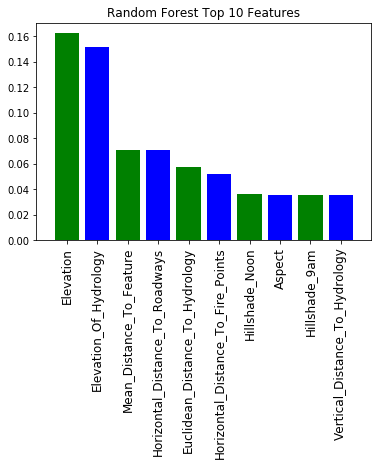

In [21]:
# Generate Initial RF and identify most important features
initialRF = RandomForestClassifier(n_estimators = 10)
initialRF.fit(e_X_train, e_y_train)
FeatImportance(initialRF, e_X_train, "Random Forest")

By taking a look at the most important features we can see which variables are most effective in predicting the cover type.  As expected the `Elevation` of an area is the biggest predictor of the `Cover_Type`.  Following the elevation of an area, we see the distances to roadways, fire points, and water all having a large effect.

### Ensemble Model

#### Approach
In the above analysis, some of the models' performance as measured by precision and recall varied widely across cover types. Most of the models did well with `Cottonwood/Willow` and poorly with `Lodgepole Pine`. We might be able to improve our results by drawing upon the strengths of each different model and take a vote to maximize the overall performance.

We use an ensemble model for this purpose. However, we also know that if our top model to date, Random Forest (RF), is more accurate than other models, there is a possibility that the noise level from the poorly performing models will reduce overall performance of the ensemble. To diagnose this, we write our code in such a way that we can also see inside the ensemble, to assess how each individual model performed.

In addition to RF, we have also tested KNN, LinearSVC and Logistic Regression models. We should take the opportunity to check other classifiers and see if they can beat our RF model. It is also important to model an ensemble of these various models with and optimizing different parameters to see if we can find a better alternative model. This is a costly and time consuming approach. Executing a GridSearch with multiple model ensembles each with 2-3 parameters often takes hours of processing even on high-end machines with many CPU cores. We, therefore, individually tested and optimized parameters for addition models such as MLP Classifier, Ada Boost, Quadratic Discriminant Analysis and Gaussian Process Classifier. Addditionally, we also varied the hyperparameters for KNN and RF individually to see the best outcome in each model. Finally, we created an ensemble model with 9 models in a "hard" and a "soft" voting model to see if we can get the best outcome.  

#### Results
Initial result showed what we suspected. The overall effect of the ensemble models were lower than the random forest. This is because the other models were adding noise to the overall. We then started process of elimination to get the best possible combination. Our simple RF can only be beaten by an ensemble model composed of KNN and RF. 

In [17]:
# Flooowing code has been tried out with multiple options 

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

#clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial',random_state=1)
clf1 =LinearSVC()
clf2 = RandomForestClassifier()
clf3 = GaussianNB()
clf4 = KNeighborsClassifier()
clf5 = SVC(gamma=2, C=1)
clf6 = GaussianProcessClassifier(1.0 * RBF(1.0))
clf7 = MLPClassifier(alpha=1,activation = 'tanh',solver = 'lbfgs' )
#clf8 = AdaBoostClassifier()
clf8 = XGBClassifier(max_depth=10, learning_rate=0.3, n_estimators=200, n_jobs=4)
clf9 = QuadraticDiscriminantAnalysis()
eclf = VotingClassifier(estimators=[
#                                    ('lsvc', clf1)
#                                    , 
#                                    ('rf', clf2)
#                                    , ('gnb', clf3)
#                                   , 
                                    ('knn', clf4)
#                                   , ('svc', clf5)
#                                   , ('gpc', clf6)
#                                   , ('mlp', clf7)
                                   , ('GB', clf8)
#                                   , ('qda', clf9)
                                   ], voting='hard')

params = {
    #    'lsvc__C': [1.0, 100.0], 
    "knn__n_neighbors":[3,5,7,],"knn__weights":["uniform","distance"],
         # 'rf__n_estimators': [5, 10], "rf__criterion": ["gini", "entropy"], "rf__min_samples_split":[5,7,10]
     }

model = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
#model.fit(scaled_FX_train, Fy_train)
#testPrediction = model.predict(scaled_FX_test)
model.fit(e_X_train, e_y_train)
testPrediction = model.predict(e_X_test)
#model.fit(X_train, y_train)
#testPrediction = model.predict(X_test)
testReport = metrics.classification_report(testPrediction, e_y_test, output_dict=True)
verbose= True
#print(f'Model: {name}')
reportFields = ['precision', 'recall', 'f1-score']
fields = sorted(testReport.keys()) if verbose else ['weighted avg']
fieldLabels = [label_names[field] if field in label_names.keys() else field for field in fields]
fieldLabels[-1] = "Final"
for i in range(len(fields)):
    output = f'\t\t{fieldLabels[i]:<20} | '
    for outputField in reportFields:
        output += f'{outputField}: {np.mean(testReport[fields[i]][outputField]):>5.2f} | '
    print(output)
for clf, label in zip([
            #clf1,
            clf2, clf3, clf4
            #, clf5,clf6,clf7,clf8,clf9
            , eclf]
            , [ 
                #"LinearSVC",
                "RandomForestClassifier"
                #,"GaussianNB()"
                ,"KNeighborsClassifier"
                #,"SVC","GaussianProcessClassifier"
                #,"MLPClassifier"
                #         ,"AdaBoostClassifier","QuadraticDiscriminantAnalysis"
                ,"Ensemble"]):
     scores = cross_val_score(clf, e_X_train, e_y_train, cv=5, scoring='accuracy')
     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label)) 

		Spruce/Fir           | precision:  0.85 | recall:  0.75 | f1-score:  0.80 | 
		Lodgepole Pine       | precision:  0.62 | recall:  0.80 | f1-score:  0.70 | 
		Ponderosa Pine       | precision:  0.89 | recall:  0.83 | f1-score:  0.86 | 
		Cottonwood/Willow    | precision:  0.97 | recall:  0.90 | f1-score:  0.94 | 
		Aspen                | precision:  0.97 | recall:  0.91 | f1-score:  0.94 | 
		Douglas Fir          | precision:  0.81 | recall:  0.96 | f1-score:  0.88 | 
		Krummholz            | precision:  0.97 | recall:  0.95 | f1-score:  0.96 | 
		macro avg            | precision:  0.87 | recall:  0.87 | f1-score:  0.87 | 
		micro avg            | precision:  0.87 | recall:  0.87 | f1-score:  0.87 | 
		Final                | precision:  0.88 | recall:  0.87 | f1-score:  0.87 | 
Accuracy: 0.84 (+/- 0.01) [RandomForestClassifier]
Accuracy: 0.61 (+/- 0.01) [KNeighborsClassifier]
Accuracy: 0.80 (+/- 0.01) [Ensemble]


In [18]:
#Note: Must fit the model prior to running this function
def FeatImportance(model, dataColumns, title): 
# Calculate the feature ranking - Top 10 
    importances = model.feature_importances_ 
    indices = np.argsort(importances)[::-1] 
    print ("%s Top 10 Features\n" %title)
    for f in range(10): 
        print("%d. %s (%f)" % (f + 1, dataColumns.columns[indices[f]], importances[indices[f]])) 
    #Mean Feature Importance 
    print ("\nMean Feature Importance %.6f" %np.mean(importances))
    #Plot the feature importances of the forest 
    indices=indices[:10] 
    plt.figure() 
    plt.title(title+" Top 10 Features") 
    plt.bar(range(10), importances[indices], color="gb", align="center") 
    plt.xticks(range(10), dataColumns.columns[indices], fontsize=12, rotation=90) 
    plt.xlim([-1, 10]) 
    plt.show()



## Master Model Result List

In [19]:
with warnings.catch_warnings(record=False):
    test_model(LogisticRegression(), e_X_train, e_y_train, e_X_test, e_y_test, name="LogisticRegression")
    
    test_model(GaussianNB(), e_X_train, e_y_train, e_X_test, e_y_test, name="GaussianNB")
    
    test_model(KNeighborsClassifier(n_neighbors=3), e_X_train, e_y_train, e_X_test, e_y_test, name="3 Nearest Neighbors")
    
    test_model(LinearSVC(), e_X_train, e_y_train, e_X_test, e_y_test, name='linearSVC')
    
    test_model(RandomForestClassifier(n_estimators = 10), e_X_train, e_y_train, e_X_test, e_y_test, name='RandomForest')
    
    test_model(XGBClassifier(max_depth=10, learning_rate=0.3, n_estimators=200, n_jobs=4), e_X_train, e_y_train, e_X_test, e_y_test, name=f'Gradient Boosted Decision Trees (XGBoost)')
    

Model: LogisticRegression
		Final                | precision:  0.67 | recall:  0.66 | f1-score:  0.67 | 
Model: GaussianNB
		Final                | precision:  0.79 | recall:  0.62 | f1-score:  0.67 | 
Model: 3 Nearest Neighbors
		Final                | precision:  0.85 | recall:  0.84 | f1-score:  0.84 | 
Model: linearSVC
		Final                | precision:  0.83 | recall:  0.35 | f1-score:  0.46 | 
Model: RandomForest
		Final                | precision:  0.84 | recall:  0.84 | f1-score:  0.84 | 
Model: Gradient Boosted Decision Trees (XGBoost)
		Final                | precision:  0.88 | recall:  0.87 | f1-score:  0.88 | 


<a id="results"></a>
    
# Results

The above results show that the bet possible model that gives consistant results is the Gradient Boosted Decision Tree. We could reach 88% precision and recall. Our experiment with the ensemble model could not improve the accuracy any further. our best modes, XGBClassifier, with learning rate of 0.3 and maximum depth of 10, when run wiht 100 estimators gives us the 88% precision, 87% recall rate and F1 Score of .88.

This model runs reasonably fast considering the complexity of the dataset. We were also careful to not to to make this model overfitted with the given dataset.

<a id="conclusion"></a>

# Conclusion

#### Most Important Features 
The story that came out of the data was, in many ways, were quire counter intuitive. At the end of the analysis, the key components.
    1. Elevation (0.162398)
    2. Elevation_Of_Hydrology (0.151600)
    3. Mean_Distance_To_Feature (0.070873)
    4. Horizontal_Distance_To_Roadways (0.070431)
    5. Euclidean_Distance_To_Hydrology (0.057154)
    6. Horizontal_Distance_To_Fire_Points (0.051782)
    7. Hillshade_Noon (0.036232)
    8. Aspect (0.035743)
    9. Hillshade_9am (0.035738)
    10. Vertical_Distance_To_Hydrology (0.035153)
We were surpised that all the details of the soil type, at the end, did not really matter for this dataset. It is true in this case may not be universally true.

#### What can be done to improve further 
    1. More Data Engineering
    Due to the time restrictions and large number of variables, we were not able to extract all possibly new features that could improve the models further.
    2. Mode model and parameter testing in ensemble
    The processing power needed to run complex combination of models, parameters take very long time to proces. and hence we could not test all possible combinations.
    


<a id="annexes"></a>
    
# Annexes

<a id="annexA"></a>

## Annex A: Exploratory Data Analysis

This appendix contains some of our exploratory data analysis. This includes the code used to generate the 4-number summaries of our data reflected in the [_About the Data_](#aboutTheData) and other summaries. The most informative portions are replicated in the main body of the report.

After we load the data from the source file, we examine the basic characteristics of the dataset.
  1. We expect to see all of the features discussed above represented in our column names
  1. As there is no separate dataset containing the labels for our observations, we would expect to see the 'Cover_Type' variable in our data
  1. We would expect to see a shape of (15120, 55) - the 54 features plus our label column

In [ ]:
print(f'Columns: {full_data.columns}')
print(f'Shape: {full_data.shape}')

We take a look at the first several observations to get a sense for the nature of the data.

In [ ]:
full_features.head()

We'll also want to get a high-level summary of each of our features.

In [ ]:
# Small function to give us a bird's-eye summary of the data
def five_num_summary(df, column):
    print(f'Column: {column:<35} | ' +
          f'Max value: {np.max(df[column]):>6} | ' + 
          f'Min value: {np.min(df[column]):>7.2f} | ' +
          f'Mean: {np.mean(df[column]):>7.2f} | ' +
          f'Median: {np.median(df[column]):>7.2f}')

for col_name in full_features.columns:
    five_num_summary(full_features, col_name)

### Checking Label Imbalance

It would be useful for us to understand whether we have an imbalanced dataset (i.e., one where certain labels/categories are overrepresented relative to others.) Here we'll quickly describe our training and test labels and just make sure our classes are balanced. We can do this both graphically and numerically.

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), sharey=True)
bins = np.arange(8) + 0.5
ax1.hist(y_train, bins, width = 0.8)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_title('Labels')
ax2.hist(y_test, bins, width = 0.8)
ax2.set_title('Test Labels')
plt.xticks(range(8))
plt.show()

In [ ]:
print(stats.describe(full_labels))
print(stats.describe(y_test))
for i in range(0, 8):
        print(f'i = {i}: Train Ct: {(full_labels==i).sum():>5} | Test Ct: {(y_test==i).sum():>5}')

It appears that our classes are quite well-balanced in both our training data and the test data.

This is good both because we will not need to deliberately compensate for imbalances and because our model will be unable to achieve reasonable performance simply by guessing the modal category. (Doing so would give accuracy on the training set of 1741/12096 = 0.145, and then accuracy on the test set of 411/3024 = 0.136.)

One thing of note is that the `Soil_Type7` and `Soil_Type15` are never true, so this feature tells us nothing.  These features should be removed before any modeling is done.

In [ ]:
bins = np.arange(0, 360, 10)
cut = [0, 45, 90, 135, 180, 225, 270, 315, 360]

print(bins)
pd.cut(bins, cut)

In [ ]:
full_data['Total_Hillshade'] = full_data[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].sum(axis=1)
full_data[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm','Total_Hillshade']].head(20)

In [ ]:
## Make 3D scatterplot to explore water, elevation, and hillshade concurrently

%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D

sparsifier = np.random.randint(0, full_features.shape[0], 5000)

sparsified = full_features.iloc[sparsifier,:]
sparse_labels = full_labels.iloc[sparsifier]
# print(f'Length of sparsified dataset\n: {sparsified}')

full_features['Euclidean_distance_to_water'] = np.sqrt(full_features['Horizontal_Distance_To_Hydrology']**2 + full_features['Vertical_Distance_To_Hydrology']**2)
dist_to_water = sparsified['Euclidean_distance_to_water']
altitude = sparsified['Elevation']
hillshade = sparsified['Hillshade_3pm']
color_dict = {1: '#A7C6ED', 2: '#BA0C2F', 3: '#651D32', 4: '#8C8985',
              5: '#212721', 6: '#002F6C', 7: '#FFC000'}
coloration = [color_dict[x] for x in sparse_labels]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hillshade, dist_to_water, altitude, color=coloration, alpha=0.6)
# ax.title('Forest cover categorization\nby distance to water and hillshade')
ax.view_init(30, 115)
# mouse_init(rotate_btn=1, zoom_btn=3)
plt.show()